# Multilabel classification on Yelp Dataset

Author: prad@berkeley.edu

This notebook is a version of the caffe example notebook for the pascal multilabel classification problem. It has been adapted for the Yelp Attribute detection problem.

### 1. Preliminaries

* First, make sure you compile caffe using
WITH_PYTHON_LAYER := 1

* Second, download Yelp Dataset to ~/Yelp. This file should be in ~/YelpVisionProject

* Third, import modules:

In [1]:
import sys 
import os

import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

from copy import copy

% matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

caffe_root = '/home/ubuntu/caffe/'  # this file is expected to be in ~/YelpProjectVision. Caffe is expected to be ~/Caffe
sys.path.append(caffe_root + 'python')
import caffe # If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

from caffe import layers as L, params as P # Shortcuts to define the net prototxt.

sys.path.append(caffe_root + 'examples/pycaffe/layers') # the datalayers we will use are in this directory.
sys.path.append(caffe_root + 'examples/pycaffe') # the tools file is in this folder

import tools #this contains some tools that we need

/home/ubuntu/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/ubuntu/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/home/ubuntu/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


* Fourth, set data directories and initialize caffe

In [2]:
# set data root directory, e.g:
yelp_root = '/home/ubuntu/Yelp/data/'

# these are the Yelp classes, we'll need them later.
classes = np.asarray(['good_for_lunch', 'good_for_dinner', 'takes_reservations', 'outdoor_seating',
                      'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy',
                      'good_for_kids'])

# make sure we have the caffenet weight downloaded.
if not os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !../caffe/scripts/download_model_binary.py ../caffe/models/bvlc_reference_caffenet

# initialize caffe for gpu mode
caffe.set_mode_gpu()
caffe.set_device(0)

### 2. Define network prototxts

* Let's start by defining the nets using caffe.NetSpec. Note how we used the SigmoidCrossEntropyLoss layer. This is the right loss for multilabel classification. Also note how the data layer is defined.

In [3]:
# helper function for common structures
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                                num_output=nout, pad=pad, group=group)
    return conv, L.ReLU(conv, in_place=True)

# another helper function
def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

# yet another helper function
def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

# main netspec wrapper
def caffenet_multilabel(data_layer_params, datalayer):
    # setup the python data layer 
    n = caffe.NetSpec()
    n.data, n.label = L.Python(module = 'yelp_multilabel', layer = datalayer, 
                               ntop = 2, param_str=str(data_layer_params))

    # the net itself
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6, n.relu6 = fc_relu(n.pool5, 4096)
    n.drop6 = L.Dropout(n.relu6, in_place=True)
    n.fc7, n.relu7 = fc_relu(n.drop6, 4096)
    n.drop7 = L.Dropout(n.relu7, in_place=True)
    n.score = L.InnerProduct(n.drop7, num_output=len(classes))
    n.loss = L.SigmoidCrossEntropyLoss(n.score, n.label)
    
    return str(n.to_proto())

### 3. Write nets and solver files

* Now we can crete net and solver prototxts. For the solver, we use the CaffeSolver class from the "tools" module

In [4]:
workdir = './yelp_multilabel_dir/'
if not os.path.isdir(workdir):
    os.makedirs(workdir)

solverprototxt = tools.CaffeSolver(trainnet_prototxt_path = osp.join(workdir, "trainnet.prototxt"),
                                   testnet_prototxt_path = osp.join(workdir, "valnet.prototxt"))
solverprototxt.sp['display'] = "1"
solverprototxt.sp['base_lr'] = "0.0001"
solverprototxt.write(osp.join(workdir, 'solver.prototxt'))

# write train net.
with open(osp.join(workdir, 'trainnet.prototxt'), 'w') as f:
    # provide parameters to the data layer as a python dictionary. Easy as pie!
    data_layer_params = dict(batch_size = 128, im_shape = [227, 227], split = 'train', yelp_root = yelp_root)
    f.write(caffenet_multilabel(data_layer_params, 'YelpMultilabelSync'))

# write validation net.
# TODO(prad): Use real validation data.
with open(osp.join(workdir, 'valnet.prototxt'), 'w') as f:
    data_layer_params = dict(batch_size = 128, im_shape = [227, 227], split = 'train', yelp_root = yelp_root)
    f.write(caffenet_multilabel(data_layer_params, 'YelpMultilabelSync'))

In [5]:
solver = caffe.SGDSolver(osp.join(workdir, 'solver.prototxt'))
solver.net.copy_from(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
solver.test_nets[0].share_with(solver.net)
solver.step(1)

BatchLoader initialized with 234842 images
YelpMultilabelSync initialized for split: train, with bs: 128, im_shape: [227, 227].
BatchLoader initialized with 234842 images
YelpMultilabelSync initialized for split: train, with bs: 128, im_shape: [227, 227].


* Let's check the data we have loaded.

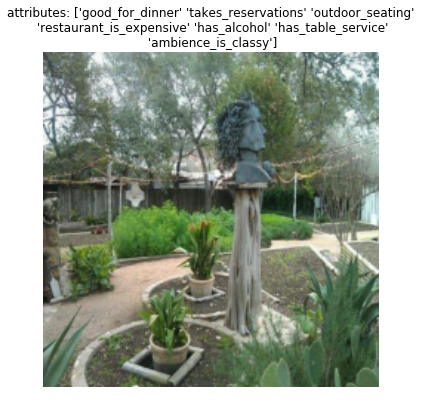

In [6]:
transformer = tools.SimpleTransformer() # This is simply to add back the bias, re-shuffle the color channels to RGB, and so on...
image_index = 4 # First image in the batch.
plt.figure()
plt.imshow(transformer.deprocess(copy(solver.net.blobs['data'].data[image_index, ...])))
attributes = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
plt.title('attributes: {}'.format(classes[np.where(attributes)]))
plt.axis('off');

* NOTE: we are readin the image from the data layer, so the resolution is lower than the original YELP image.

### 4. Train a net.

* Let's train the net. First, though, we need some way to measure the accuracy. Hamming distance is commonly used in multilabel problems. We also need a simple test loop. Let's write that down. 

In [7]:
def hamming_distance(gt, est):
    return sum([1 for (g, e) in zip(gt, est) if g == e]) / float(len(gt))

def check_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = net.blobs['score'].data > 0
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

In [8]:
# Now let it train for a while.
for itt in range(1):
    solver.step(10)
    print 'itt:{:3d}'.format((itt + 1) * 100), 'accuracy:{0:.4f}'.format(check_accuracy(solver.test_nets[0], 50))

itt:100 accuracy:0.6605


Make sure that the accuracy is improving. And check for convergence

In [9]:
def check_baseline_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = np.zeros((batch_size, len(gts)))
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

print 'Baseline accuracy:{0:.4f}'.format(check_baseline_accuracy(solver.test_nets[0], 5823/128))

Baseline accuracy:0.4600


### 6. Look at some prediction results

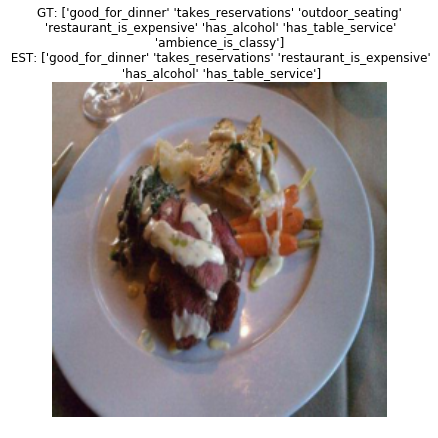

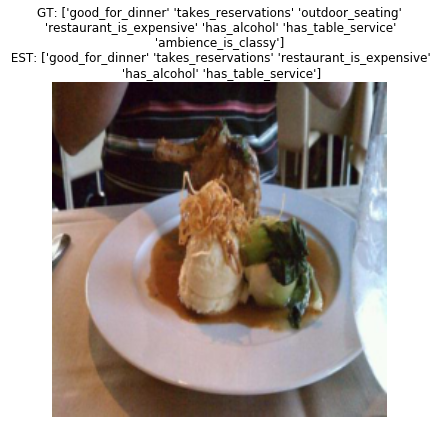

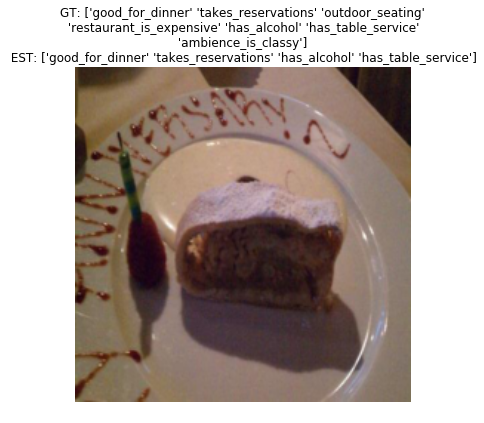

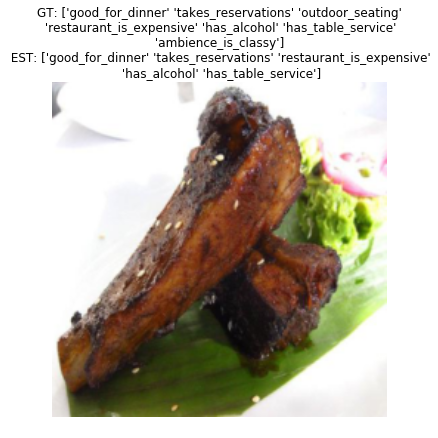

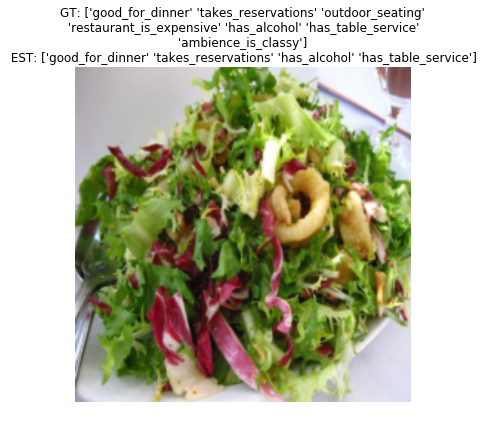

In [10]:
test_net = solver.test_nets[0]
for image_index in range(5):
    plt.figure()
    plt.imshow(transformer.deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
    gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
    estlist = test_net.blobs['score'].data[image_index, ...] > 0
    plt.title('GT: {} \n EST: {}'.format(classes[np.where(gtlist)], classes[np.where(estlist)]))
    plt.axis('off')